# Wahltinez Sea Star Diseased vs Healthy

In [1]:
%matplotlib inline
import math
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Adjust font sizes for all plots
import matplotlib 
matplotlib.rc('font', size=14)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

### Read biomarker data from local file
Break up dataset based on designation category, and clean up bogus values like "<175" by excluding them from the data.

In [3]:
df_bio = pd.read_csv('seastar_salinity.csv')

# Separate diseased, healthy and water groups
group_names = df_bio['Designation'].unique().tolist()
groups = {group: df_bio[df_bio['Designation'] == group].copy() for group in group_names}
print('Designation categories: %s' % group_names)

# Define labels that we want to analyze statistically
biomarkers = ['Mg', 'Na', 'K', 'Cl', 'Ca', 'TotP', 'Cell', 'Salinity']
cols = biomarkers + ['Score']

def cleanup_group(df):
    
    def to_number(val):
        try:
            val = float(val)
        except:
            val = np.nan
        return val
    
    # Replace non-numerical values with the numerical equivalents
    for col in cols:
        df[col] = df[col].apply(to_number).astype(float)
        
    # Remove samples without score
    df = df[~df['Score'].isna()].copy()
    
    # Score is a whole number, not floating point
    df['Score'] = df['Score'].astype(int)
        
    # Correct units in some measurements
    if 'TotP' in df.columns: df['TotP'] *= 10  # From g/dL to g/L
    if 'Ca' in df.columns: df['Ca'] *= .5  # From mEq/L to mmol/L
    if 'Mg' in df.columns: df['Mg'] *= .5  # From mEq/L to mmol/L
        
    # Return only the column subset
    return df[cols]
    
df_bio = cleanup_group(df_bio[df_bio['Designation'] != 'Water'].copy())
groups = {cat: cleanup_group(df.copy()) for cat, df in groups.items()}

Designation categories: ['Diseased', 'Healthy', 'Water']


### Display basic stats for the diseased population of sea stars

In [4]:
# Function used to display units in the y-axis, defaults to mmol/L
y_label = lambda x: {
    'TotP': 'g/L',
    'Cell': 'cells/ul',
    'Salinity': 'ppt',
    'Osmolality': 'mOsm/kgH2O'}.get(x) or 'mmol/L'

diseased_stats = []
for col in biomarkers:

    # Separate data for specific feature
    vec = groups['Diseased'][col].dropna()
    diseased_stats.append({
        'Measurement': col,
        'Unit': y_label(col),
        'Mean': vec.mean(),
        'Median': vec.median(),
        'Std': vec.std(),
        'Range': '(%.1f, %.1f)' % (vec.min(), vec.max())})

pd.DataFrame(diseased_stats).set_index('Measurement')

Unit         Mean  Median           Std           Range
Measurement                                                             
Mg             mmol/L    46.358537   48.30      7.536262    (16.4, 54.0)
Na             mmol/L   411.878049  407.00     15.844865  (381.0, 463.0)
K              mmol/L     8.809756    8.20      1.886638     (7.8, 19.1)
Cl             mmol/L   473.153846  479.00     25.739115  (427.0, 553.0)
Ca             mmol/L     8.675610    8.85      1.030602     (4.2, 10.3)
TotP              g/L   206.578947  200.00     69.604144  (120.0, 500.0)
Cell         cells/ul  6125.890909  900.00  12393.102851  (0.0, 60750.0)
Salinity          ppt    30.209091   30.00      0.797513    (29.0, 32.0)

### Establish normality for each measurement
Plot data against lines at 2σ and 3σ and compute the probability of the data belonging to a normal distribution.

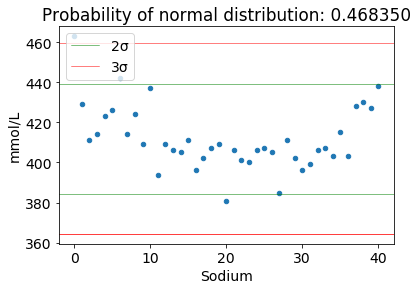

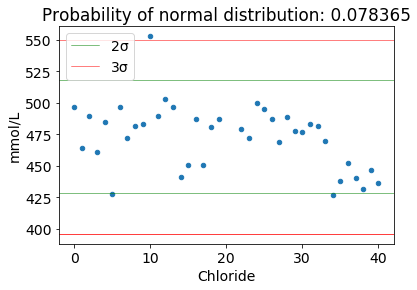

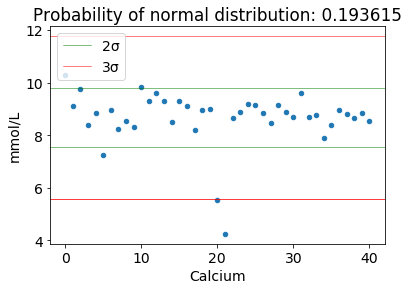

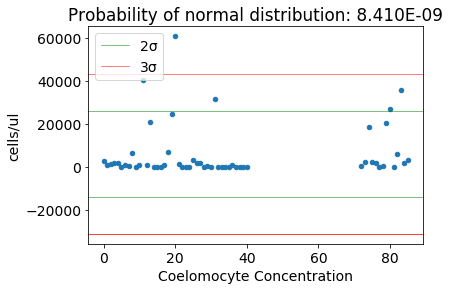

In [5]:
# Helper function used to format very small p-values
format_p_value = lambda p: ('%.3E' if p < 1E-2 else '%.06f') % p

# Helper function used to format column names
col_name = lambda x: {
    'Mg': 'Magnesium',
    'Na': 'Sodium',
    'K': 'Potassium',
    'Cl': 'Chloride',
    'Ca': 'Calcium',
    'TotP': 'Total Protein',
    'Cell': 'Coelomocyte Concentration'}.get(x) or x

for col in biomarkers:
    
    # Separate data for specific feature
    vec = groups['Diseased'][col].dropna()
    
    # Plot data against 3 * std over and under mean
    mean = vec.mean()
    std3 = vec.std() * 3
    df_ = vec.to_frame()
    df_['#'] = df_.index.copy()
    ax = df_.plot(title=col, kind='scatter', x='#', y=col)
    ax.set_xlabel(col_name(col))
    ax.set_ylabel(y_label(col))
    sigma3 = ax.axhline(y=mean-std3, c="red", linewidth=0.5, label='3σ')
    ax.axhline(y=mean-std3, c="red", linewidth=0.5)
    ax.axhline(y=mean+std3, c="red", linewidth=0.5)
    
    # Drop outliers
    vec[(vec > mean + std3) | (vec < mean - std3)] = np.nan
    vec.dropna(inplace=True)
    
    # Plot estimated upper and lower limits
    std2 = vec.std() * 2
    sigma2 = ax.axhline(y=mean-std2, c="green", linewidth=0.5, label='2σ')
    ax.axhline(y=mean+std2, c="green", linewidth=0.5)
    ax.legend(loc=2, handles=[sigma2, sigma3])
    
    # Compute probability of normal distribution
    _, p_norm = scipy.stats.mstats.normaltest(vec)

    plt.title('Probability of normal distribution: %s' % format_p_value(p_norm))
    plt.show()

### Display box plots comparing between healthy and diseased sea stars
The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box. Outlier points are those past the end of the whiskers.

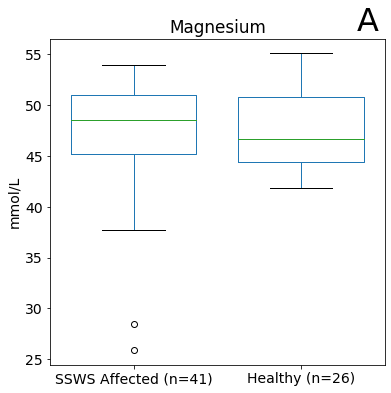

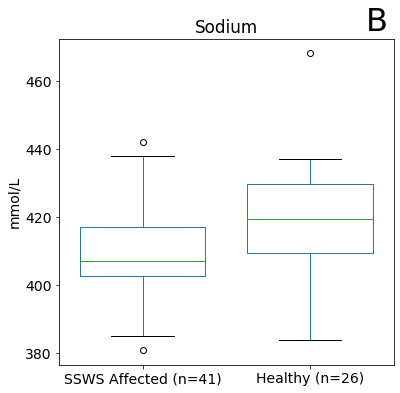

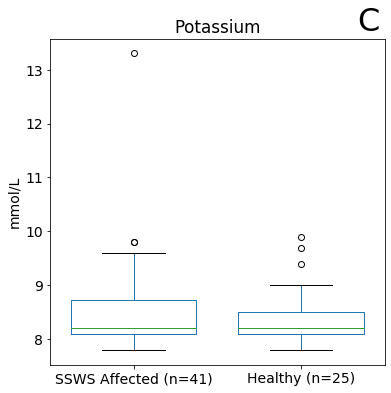

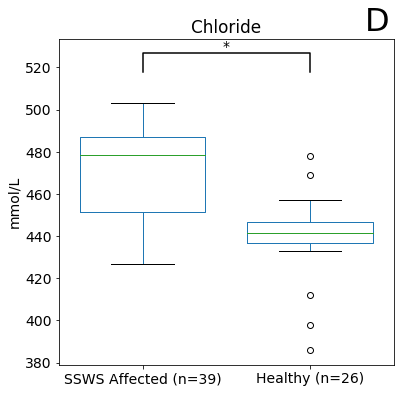

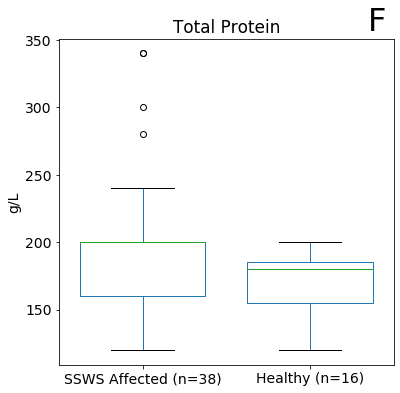

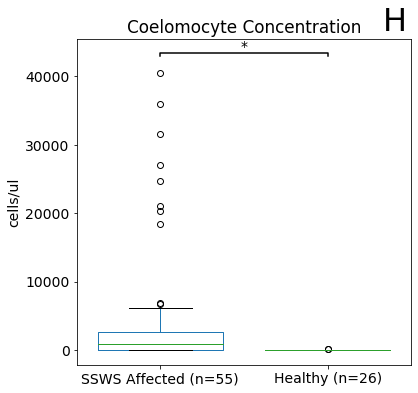

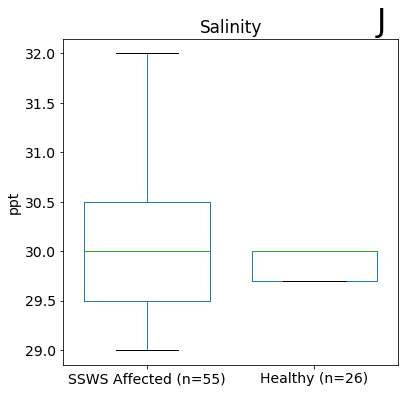

In [6]:
# Function used to identify outliers in the data
def outliers_mask(name, vec, sigma_threshold=3, log=True):
    vec_ = vec.copy()
    mean = vec.mean()
    std_threshold = vec.std() * sigma_threshold
    vec[vec < mean - std_threshold] = np.nan
    vec[vec > mean + std_threshold] = np.nan
    mask = np.isnan(vec)
    nan_count = len(vec[mask])
    if nan_count > 0 and log:
        print('Removing %d outliers from %s' % (nan_count, name))
        
    return mask

for letter, col in zip('ABCDEFHJ', biomarkers):
        
    # Separate data for specific feature
    vec1 = groups['Diseased'][col].dropna()
    vec2 = groups['Healthy'][col].dropna()
    vec1.name = 'SSWS Affected (n=%d)' % len(vec1)
    vec2.name = 'Healthy (n=%d)' % len(vec2)
        
    # Remove outliers
    mask1 = outliers_mask('Healthy %s' % col, vec1, log=False)
    mask2 = outliers_mask('SSWS Affected %s' % col, vec2, log=False)
    vec1 = vec1[~mask1]
    vec2 = vec2[~mask2]
    
    df_ = pd.concat([vec1, vec2], axis=1)
    ax = df_.boxplot(figsize=(6, 6), grid=False, widths=0.75)
    ax.set_title(col_name(col))
    ax.set_ylabel(y_label(col))
    ax.text(.95, 1.05, letter, fontsize=32, color='k',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)

#     if col == 'Cell':
#         ax.set_ylim(None, max(vec1.max(), vec2.max()) * 1.1)

    # Draw statistical annotation over significant values
    if col in ('Ca', 'Cl', 'Cell'):
        x1, x2 = 1, 2
        min_val, max_val = ax.get_ylim()
        mid_val = (max_val + min_val) / 2
        gap = mid_val / 100
        y, h, color = max_val + gap * 2, gap * 2, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=color)
    
    plt.show()

### Compute T-tests comparing healthy and diseased sea stars
T-tests are used to determine if the distributions for diseased vs healthy groups are likely to be the same. Different T-tests make different assumptions. Not all tests may be applicable to our data but it is good to compare their results to spot trends. ANOVA, Student's T-test and Welch's T-test assume normality, while Kruskal-Wallis is non-parametric.

In [7]:
ttest_results = []

for col in biomarkers:

    # Separate data for specific feature
    vec1 = groups['Healthy'][col].dropna()
    vec2 = groups['Diseased'][col].dropna()
    vec1.name = 'SSWS Affected'
    vec2.name = 'Healthy'
    
    # Remove outliers
    mask1 = outliers_mask('Healthy %s' % col_name(col), vec1)
    mask2 = outliers_mask('SSWS Affected %s' % col_name(col), vec2)
    vec1 = vec1[~mask1]
    vec2 = vec2[~mask2]           
    
    # Perform one-way ANOVA test
    s_anova, p_anova = scipy.stats.f_oneway(vec1, vec2)
    
    # Perform two-sided independent T-test
    s_ttest, p_ttest = scipy.stats.ttest_ind(vec1, vec2, equal_var=True)
    
    # Perform Welch's T-test
    s_welch, p_welch = scipy.stats.ttest_ind(vec1, vec2, equal_var=False)
    
    # Perform Kruskal-Wallis H-test
    s_kruskal, p_kruskal = scipy.stats.kruskal(vec1, vec2)
    
    # Store in records
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'ANOVA',
        'Statistic': format_p_value(s_anova),
        'p-value': format_p_value(p_anova)})
#     ttest_results.append({
#         'Measurement': col_name(col),
#         'Test': 'Independent Two-Sided T-test',
#         'Statistic': format_p_value(s_ttest),
#         'p-value': format_p_value(p_ttest)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Welch\'s T-test',
        'Statistic': format_p_value(s_welch),
        'p-value': format_p_value(p_welch)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Kruskal-Wallis',
        'Statistic': format_p_value(s_kruskal),
        'p-value': format_p_value(p_kruskal)})

# Output comnputed probabilities
pd.DataFrame(ttest_results).set_index(['Measurement', 'Test'])

Removing 1 outliers from SSWS Affected Magnesium
Removing 1 outliers from SSWS Affected Sodium
Removing 1 outliers from SSWS Affected Potassium
Removing 1 outliers from SSWS Affected Chloride
Removing 2 outliers from SSWS Affected Calcium
Removing 1 outliers from SSWS Affected Total Protein
Removing 1 outliers from Healthy Coelomocyte Concentration
Removing 1 outliers from SSWS Affected Coelomocyte Concentration


Statistic    p-value
Measurement               Test                                 
Magnesium                 ANOVA             0.091998   0.762636
                          Welch's T-test    0.330740   0.741922
                          Kruskal-Wallis    0.181968   0.669688
Sodium                    ANOVA             4.129435   0.046298
                          Welch's T-test    1.917881   0.061726
                          Kruskal-Wallis    4.954113   0.026029
Potassium                 ANOVA             0.298175   0.586958
                          Welch's T-test  -6.114E-01   0.543147
                          Kruskal-Wallis   1.153E-03   0.972913
Chloride                  ANOVA            33.501267  2.532E-07
                          Welch's T-test  -5.992E+00  1.296E-07
                          Kruskal-Wallis   19.572552  9.685E-06
Calcium                   ANOVA             6.356089   0.014241
                          Welch's T-test    2.077061   0.047795
                          Kruskal-Wallis    0.371765   0.542044
Total Protein             ANOVA             4.655328   0.035691
                          Welch's T-test  -2.754E+00  8.199E-03
                          Kruskal-Wallis    4.828220   0.027998
Coelomocyte Concentration ANOVA             6.531274   0.012570
                          Welch's T-test  -3.769E+00  4.135E-04
                          Kruskal-Wallis   27.563259  1.520E-07
Salinity                  ANOVA             4.207511   0.043560
                          Welch's T-test  -2.912E+00  4.997E-03
                          Kruskal-Wallis    2.154983   0.142108

### Compute correlation coefficients between score and biomarkers
Pearson, Spearman and Kendall correlation coefficients are computed, and the resulting p-value of the likelihood that the score and each biomarker are correlated is reported. We also show a scatter plot comparing each biomarker and the different scores.

Removing 2 outliers from Magnesium
Removing 1 outliers from Sodium
Removing 2 outliers from Potassium
Removing 1 outliers from Chloride
Removing 2 outliers from Calcium
Removing 1 outliers from Total Protein
Removing 3 outliers from Coelomocyte Concentration


Statistic    p-value
Measurement               Test                           
Calcium                   Kendall     0.129314   0.173192
                          Pearson   -1.711E-01   0.172952
                          Spearman    0.169662   0.176652
Chloride                  Kendall     0.461459  1.484E-06
                          Pearson     0.673864  1.043E-09
                          Spearman    0.629960  2.444E-08
Coelomocyte Concentration Kendall     0.539698  4.676E-09
                          Pearson     0.335846  2.647E-03
                          Spearman    0.672613  1.539E-11
Magnesium                 Kendall     0.178585   0.058668
                          Pearson     0.101312   0.421959
                          Spearman    0.224220   0.072561
Potassium                 Kendall     0.085032   0.388206
                          Pearson     0.061579   0.628827
                          Spearman    0.116872   0.357725
Salinity                  Kendall   -1.016E-01   0.267831
                          Pearson   -4.197E-02   0.709897
                          Spearman  -1.507E-01   0.179344
Sodium                    Kendall   -1.317E-01   0.162440
                          Pearson   -1.389E-01   0.265906
                          Spearman  -1.725E-01   0.165928
Total Protein             Kendall     0.167402   0.132119
                          Pearson     0.242405   0.080318
                          Spearman    0.181539   0.193275

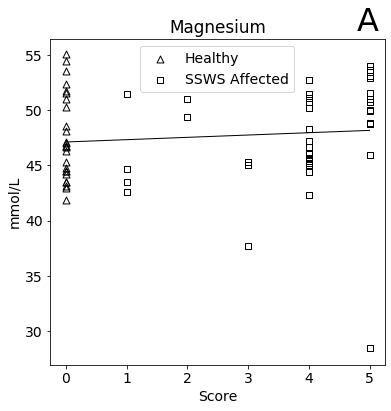

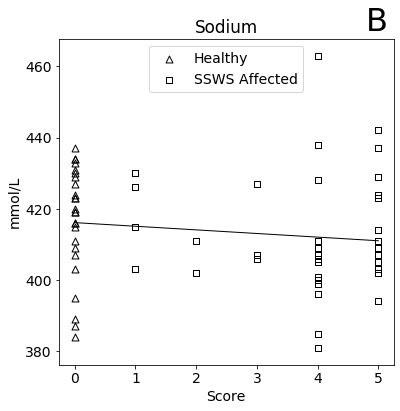

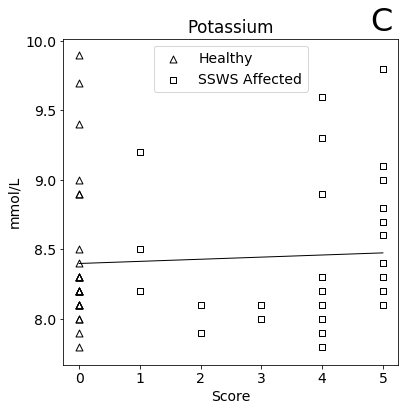

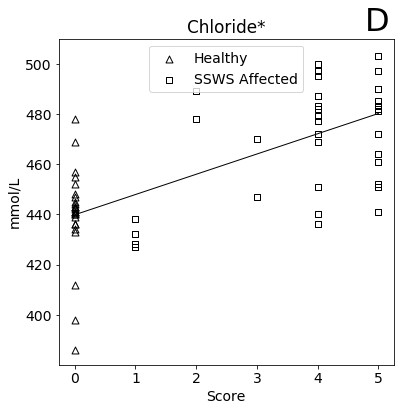

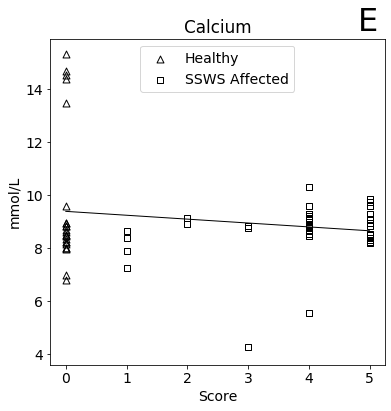

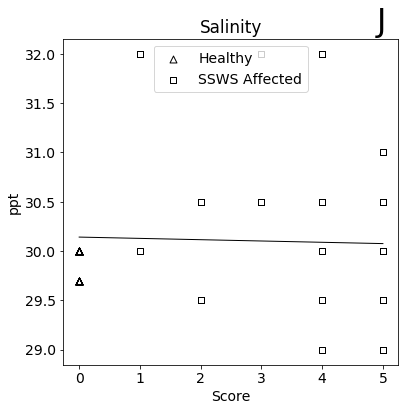

In [8]:
ttest_results = []

# Statistically significant columns
cols_sig = ('Cl', 'Cell')

# Iterate over each analyte
for letter, col in zip('ABCDEFHJ', biomarkers):

    # Separate data for specific feature
    mask1 = df_bio[col].isna()
    vec1 = df_bio['Score'][~mask1]
    vec2 = df_bio[col][~mask1]

    # Remove outliers from analyte
    mask2 = outliers_mask('%s' % col_name(col), vec2)
    vec1 = vec1[~mask2]
    vec2 = vec2[~mask2]
    
    # Draw a scatter plot
    df_ = pd.concat([vec1, vec2], axis=1)
    ax = df_[df_['Score'] == 0].plot(
        kind='scatter', figsize=(6, 6), grid=False, x='Score', y=col,
        marker='^', edgecolor='black', color='none', s=48, label='Healthy')
    ax = df_[df_['Score'] != 0].plot(
        ax=ax, kind='scatter', figsize=(6, 6), grid=False, x='Score', y=col,
        marker='s', edgecolor='black', color='none', s=48, label='SSWS Affected')
    ax.legend(loc='upper center')
    ax.set_title(col_name(col) + ('*' if col in cols_sig else ''))
    ax.set_ylabel(y_label(col))
    ax.text(.95, 1.05, letter, fontsize=32, color='k',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)
    
    # Draw the linear regression line
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_['Score'], df_[col])
    linreg_x = np.array(range(0, df_['Score'].max() + 1))
    linreg_y = slope * linreg_x + intercept
    x1, x2 = linreg_x[0], linreg_x[-1]
    y1, y2 = linreg_y[0], linreg_y[-1]
    plt.plot([x1, x2], [y1, y2], lw=1, c='k')

    # Compute Pearson correlation coefficient
    s_pearson, p_pearson = scipy.stats.pearsonr(vec1, vec2)

    # Compute Spearman correlation coefficient
    s_spearman, p_spearman = scipy.stats.spearmanr(vec1, vec2)

    # Compute Kendall correlation coefficient
    s_kendall, p_kendall = scipy.stats.kendalltau(vec1, vec2)

    # Store in records
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Pearson',
        'Statistic': format_p_value(s_pearson),
        'p-value': format_p_value(p_pearson)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Spearman',
        'Statistic': format_p_value(s_spearman),
        'p-value': format_p_value(p_spearman)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Kendall',
        'Statistic': format_p_value(s_kendall),
        'p-value': format_p_value(p_kendall)})

# Output comnputed probabilities
pd.DataFrame(ttest_results).set_index(['Measurement', 'Test']).sort_index()

### Compare coelomocyte counts for non-heparanized vs EDTA
Since records in both sets of samples are taken from the same individual, we perform a paired T-test.

Removing 1 outliers from Not-Heparanized Coemocyte Count
Removing 2 outliers from EDTA Coelomocyte Count


Test Statistic   p-value
Measurement                                                           
Coelomocyte Concentration  Paired Two-Sided T-test  0.923343  0.360981

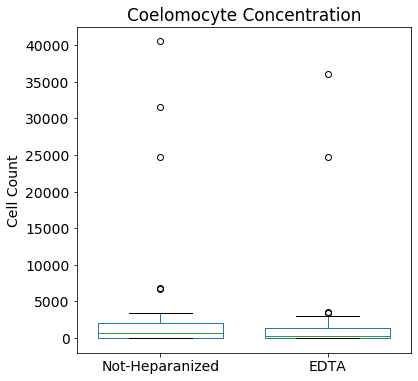

In [9]:
df_edta = pd.read_csv('nonhep_vs_edta.csv').dropna().set_index('ID')

# Extract column vectors from data
col1 = 'Not-Heparanized Coemocyte Count'
col2 = 'EDTA Coelomocyte Count'
vec1 = df_edta[col1].copy()
vec2 = df_edta[col2].copy()
vec1.name = 'Not-Heparanized'
vec2.name = 'EDTA'

# Remove outliers
mask1 = outliers_mask(col1, vec1)
mask2 = outliers_mask(col2, vec2)
vec1 = vec1[~mask1 & ~mask2]
vec2 = vec2[~mask1 & ~mask2]

# Draw boxplot
df_ = pd.concat([vec1, vec2], axis=1)
ax = df_.boxplot(figsize=(6, 6), grid=False, widths=0.75)
ax.set_title('Coelomocyte Concentration')
ax.set_ylabel('Cell Count')

# Compute paired t-test score
s_ttest, p_ttest = scipy.stats.ttest_rel(vec1, vec2)

# Store in records
ttest_results = [{
    'Measurement': 'Coelomocyte Concentration',
    'Test': 'Paired Two-Sided T-test',
    'Statistic': format_p_value(s_ttest),
    'p-value': format_p_value(p_ttest)}]

# Output comnputed probabilities
pd.DataFrame(ttest_results).set_index('Measurement')

### Read osmolality data
Since osmolality was measured with a different population, this analysis cannot be done with the rest of the biomarkers.

In [10]:
df_osmo = pd.read_csv('seastar_osmolality.csv')
def infer_designation(score):
    if score == 0:
        return 'Healthy'
    elif score > 0:
        return 'Diseased'
    else:
        return 'Water'
df_osmo['Designation'] = df_osmo['Score'].apply(infer_designation)
        
# Remove samples without score
df_osmo = df_osmo[~df_osmo['Score'].isna()].copy()

# Score is a whole number, not floating point
df_osmo['Score'] = df_osmo['Score'].astype(int)

# Separate diseased, healthy and water groups
group_names_osmo = df_osmo['Designation'].unique().tolist()
groups_osmo = {group: df_osmo[df_osmo['Designation'] == group].copy() for group in group_names_osmo}

# Define labels that we want to analyze statistically
biomarkers = ['Osmolality', 'Salinity']
cols = list(biomarkers)
col = cols[0]

# Cleanup each designation
groups = {cat: cleanup_group(df.copy()) for cat, df in groups_osmo.items()}

### Display basic stats for the osmolality of diseased sea stars

In [11]:
osmolality_stats = []
for col in biomarkers:

    # Separate data for specific feature
    vec = groups_osmo['Diseased'][col].dropna()
    osmolality_stats.append({
        'Measurement': col,
        'Unit': y_label(col),
        'Mean': vec.mean(),
        'Median': vec.median(),
        'Std': vec.std(),
        'Range': '(%.1f, %.1f)' % (vec.min(), vec.max())})

pd.DataFrame(osmolality_stats).set_index('Measurement')

Unit     Mean  Median      Std           Range
Measurement                                                      
Osmolality   mOsm/kgH2O  875.125   874.5  4.35685  (870.0, 882.0)
Salinity            ppt   29.625    29.0  1.06066    (29.0, 32.0)

### Compare osmolality between healthy and diseased sea stars

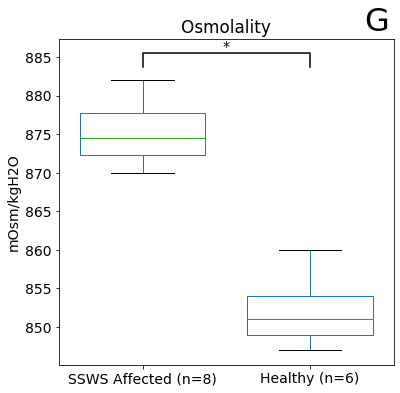

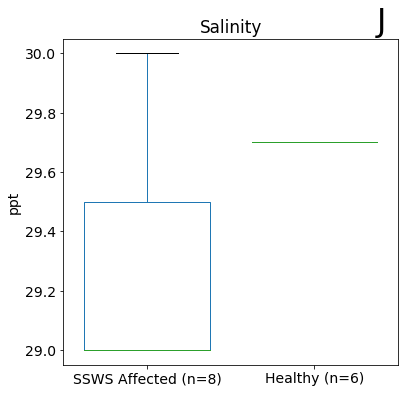

In [12]:
for letter, col in zip('GJ', biomarkers):
        
    # Separate data for specific feature
    vec1 = groups_osmo['Diseased'][col].dropna()
    vec2 = groups_osmo['Healthy'][col].dropna()
    vec1.name = 'SSWS Affected (n=%d)' % len(vec1)
    vec2.name = 'Healthy (n=%d)' % len(vec2)
        
    # Remove outliers
    threshold = 2 if col == 'Osmolality' else 3
    mask1 = outliers_mask('Healthy %s' % col, vec1, sigma_threshold=2, log=False)
    mask2 = outliers_mask('SSWS Affected %s' % col, vec2, sigma_threshold=2, log=False)
    vec1 = vec1[~mask1]
    vec2 = vec2[~mask2]
    
    df_ = pd.concat([vec1, vec2], axis=1)
    ax = df_.boxplot(figsize=(6, 6), grid=False, widths=0.75)
    ax.set_title(col_name(col))
    ax.set_ylabel(y_label(col))
    ax.text(.95, 1.05, letter, fontsize=32, color='k',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)

    # Draw statistical annotation over significant values
    if col in ('Osmolality'):
        x1, x2 = 1, 2
        max_val = df_.max().max()
        min_val = df_.min().min()
        mid_val = (max_val + min_val) / 2
        gap = mid_val / 1000
        y, h, color = max_val + gap * 2, gap * 2, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=color)
    
    plt.show()

### Compute T-tests comparing healthy and diseased sea stars
T-tests are used to determine if the distributions for diseased vs healthy groups are likely to be the same. Different T-tests make different assumptions. Not all tests may be applicable to our data but it is good to compare their results to spot trends. ANOVA, Student's T-test and Welch's T-test assume normality, while Kruskal-Wallis is non-parametric.

In [13]:
ttest_results = []

for col in biomarkers:

    # Separate data for specific feature
    vec1 = groups_osmo['Healthy'][col].dropna()
    vec2 = groups_osmo['Diseased'][col].dropna()
    vec1.name = 'SSWS Affected'
    vec2.name = 'Healthy'
    
    # Remove outliers
    mask1 = outliers_mask('Healthy %s' % col_name(col), vec1)
    mask2 = outliers_mask('SSWS Affected %s' % col_name(col), vec2)
    vec1 = vec1[~mask1]
    vec2 = vec2[~mask2]           
    
    # Perform one-way ANOVA test
    s_anova, p_anova = scipy.stats.f_oneway(vec1, vec2)
    
    # Perform two-sided independent T-test
    s_ttest, p_ttest = scipy.stats.ttest_ind(vec1, vec2, equal_var=True)
    
    # Perform Welch's T-test
    s_welch, p_welch = scipy.stats.ttest_ind(vec1, vec2, equal_var=False)
    
    # Perform Kruskal-Wallis H-test
    s_kruskal, p_kruskal = scipy.stats.kruskal(vec1, vec2)
    
    # Store in records
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'ANOVA',
        'Statistic': format_p_value(s_anova),
        'p-value': format_p_value(p_anova)})
#     ttest_results.append({
#         'Measurement': col_name(col),
#         'Test': 'Independent Two-Sided T-test',
#         'Statistic': format_p_value(s_ttest),
#         'p-value': format_p_value(p_ttest)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Welch\'s T-test',
        'Statistic': format_p_value(s_welch),
        'p-value': format_p_value(p_welch)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Kruskal-Wallis',
        'Statistic': format_p_value(s_kruskal),
        'p-value': format_p_value(p_kruskal)})

# Output comnputed probabilities
pd.DataFrame(ttest_results).set_index(['Measurement', 'Test'])

Statistic    p-value
Measurement Test                                 
Osmolality  ANOVA             4.766875   0.049598
            Welch's T-test  -1.867E+00   0.120461
            Kruskal-Wallis    9.621145  1.923E-03
Salinity    ANOVA             0.080863   0.780979
            Welch's T-test    0.330409   0.750437
            Kruskal-Wallis    0.904096   0.341686

### Compute correlation coefficients between score and osmolality
Pearson, Spearman and Kendall correlation coefficients are computed, and the resulting p-value of the likelihood that the score and each biomarker are correlated is reported. We also show a scatter plot comparing each biomarker and the different scores.

Removing 1 outliers from Osmolality


Statistic    p-value
Measurement Test                           
Osmolality  Kendall     0.694704  2.114E-03
            Pearson     0.906406  1.950E-05
            Spearman    0.847557  2.537E-04
Salinity    Kendall   -5.798E-02   0.806669
            Pearson     0.101907   0.728851
            Spearman  -1.701E-02   0.953973

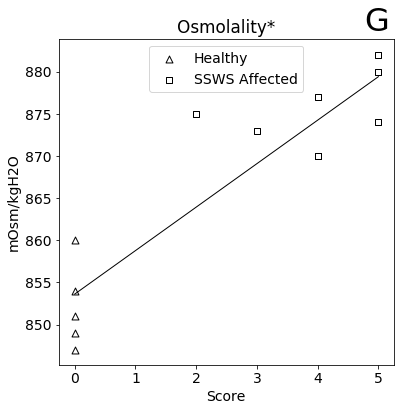

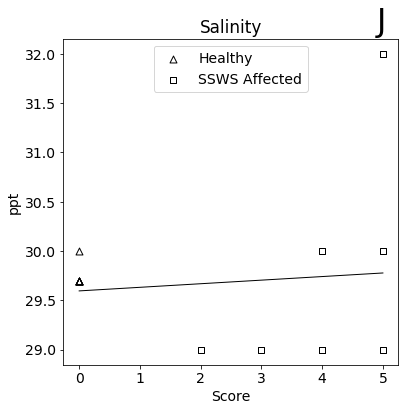

In [14]:
ttest_results = []

# Iterate over each analyte
for letter, col in zip('GJ', biomarkers):

    # Separate data for specific feature
    mask1 = df_osmo[col].isna()
    vec1 = df_osmo['Score'][~mask1]
    vec2 = df_osmo[col][~mask1]

    # Remove outliers from analyte
    mask2 = outliers_mask('%s' % col_name(col), vec2)
    vec1 = vec1[~mask2]
    vec2 = vec2[~mask2]
    
    # Draw a scatter plot
    df_ = pd.concat([vec1, vec2], axis=1)
    ax = df_[df_['Score'] == 0].plot(
        kind='scatter', figsize=(6, 6), grid=False, x='Score', y=col,
        marker='^', edgecolor='black', color='none', s=48, label='Healthy')
    ax = df_[df_['Score'] != 0].plot(
        ax=ax, kind='scatter', figsize=(6, 6), grid=False, x='Score', y=col,
        marker='s', edgecolor='black', color='none', s=48, label='SSWS Affected')
    ax.legend(loc='upper center')
    ax.set_title(col_name(col) + ('*' if col in 'Osmolality' else ''))
    ax.set_ylabel(y_label(col))
    ax.text(.95, 1.05, letter, fontsize=32, color='k',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)
    
    # Draw the linear regression line
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_['Score'], df_[col])
    linreg_x = np.array(range(0, df_['Score'].max() + 1))
    linreg_y = slope * linreg_x + intercept
    x1, x2 = linreg_x[0], linreg_x[-1]
    y1, y2 = linreg_y[0], linreg_y[-1]
    plt.plot([x1, x2], [y1, y2], lw=1, c='k')

    # Compute Pearson correlation coefficient
    s_pearson, p_pearson = scipy.stats.pearsonr(vec1, vec2)

    # Compute Spearman correlation coefficient
    s_spearman, p_spearman = scipy.stats.spearmanr(vec1, vec2)

    # Compute Kendall correlation coefficient
    s_kendall, p_kendall = scipy.stats.kendalltau(vec1, vec2)

    # Store in records
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Pearson',
        'Statistic': format_p_value(s_pearson),
        'p-value': format_p_value(p_pearson)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Spearman',
        'Statistic': format_p_value(s_spearman),
        'p-value': format_p_value(p_spearman)})
    ttest_results.append({
        'Measurement': col_name(col),
        'Test': 'Kendall',
        'Statistic': format_p_value(s_kendall),
        'p-value': format_p_value(p_kendall)})

# Output comnputed probabilities
pd.DataFrame(ttest_results).set_index(['Measurement', 'Test']).sort_index()